In [1]:
4+12

16

In [3]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import minimize
from datasets import load_dataset
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')

# Load STS Benchmark dataset
dataset = load_dataset("stsb_multi_mt", "en")
# Convert dataset into DataFrame
df = pd.DataFrame(dataset["train"])
df = df[["sentence1", "sentence2", "similarity_score"]].dropna()
df.to_csv('output.csv', index=False)
# Normalize similarity scores to [0,1] range
df["similarity_score"] = df["similarity_score"] / 5.0

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

# Calculate TF-IDF vectors
vectorizer = TfidfVectorizer()
sentences = df['sentence1'].tolist() + df['sentence2'].tolist()
tfidf_matrix = vectorizer.fit_transform(sentences)

# Calculate similarity scores
def calculate_similarities(text1, text2):
    # Preprocess texts
    text1_proc = preprocess_text(text1)
    text2_proc = preprocess_text(text2)
    
    # Get TF-IDF vectors
    vec1 = vectorizer.transform([text1_proc])
    vec2 = vectorizer.transform([text2_proc])
    
    # Calculate cosine similarity
    cosine_sim = cosine_similarity(vec1, vec2)[0][0]
    
    # Calculate Euclidean similarity (normalized)
    eucl_dist = euclidean(vec1.toarray()[0], vec2.toarray()[0])
    eucl_sim = 1 / (1 + eucl_dist)  # Convert distance to similarity
    
    # Calculate Jaccard similarity
    set1 = set(text1_proc.split())
    set2 = set(text2_proc.split())
    jaccard_sim = len(set1.intersection(set2)) / len(set1.union(set2))
    
    return cosine_sim, eucl_sim, jaccard_sim

# Calculate all similarity scores for the dataset
similarities = df.apply(lambda row: calculate_similarities(row['sentence1'], row['sentence2']), axis=1)
df['cosine_sim'] = [s[0] for s in similarities]
df['euclidean_sim'] = [s[1] for s in similarities]
df['jaccard_sim'] = [s[2] for s in similarities]

# Define hybrid similarity function
def hybrid_similarity(weights, sims):
    return np.clip(
        weights[0] * sims[0] +  # cosine
        weights[1] * sims[1] +  # euclidean
        weights[2] * sims[2],   # jaccard
        0, 1
    )

# Optimize weights
def objective(weights):
    predicted_scores = df.apply(
        lambda row: hybrid_similarity(
            weights, 
            [row['cosine_sim'], row['euclidean_sim'], row['jaccard_sim']]
        ),
        axis=1
    )
    return mean_squared_error(df['similarity_score'], predicted_scores)

# Set up optimization constraints
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # weights sum to 1
bounds = [(0, 1)] * 3  # weights between 0 and 1

# Optimize weights
initial_weights = [1/3, 1/3, 1/3]
result = minimize(
    objective,
    initial_weights,
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

optimized_weights = result.x

# Calculate hybrid scores with optimized weights
df['hybrid_sim'] = df.apply(
    lambda row: hybrid_similarity(
        optimized_weights,
        [row['cosine_sim'], row['euclidean_sim'], row['jaccard_sim']]
    ),
    axis=1
)

# Calculate correlations with human scores
correlations = {
    'Cosine': pearsonr(df['similarity_score'], df['cosine_sim'])[0],
    'Euclidean': pearsonr(df['similarity_score'], df['euclidean_sim'])[0],
    'Jaccard': pearsonr(df['similarity_score'], df['jaccard_sim'])[0],
    'Hybrid': pearsonr(df['similarity_score'], df['hybrid_sim'])[0]
}

# Visualization
plt.figure(figsize=(15, 10))

# Create scatter plots
metrics = ['cosine_sim', 'euclidean_sim', 'jaccard_sim', 'hybrid_sim']
titles = ['Cosine Similarity', 'Euclidean Similarity', 'Jaccard Similarity', 'Hybrid Similarity']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(data=df, x='similarity_score', y=metric, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.title(f'{title} vs Human Scores\nr = {correlations[title.split()[0]]:.3f}')
    plt.xlabel('Human Similarity Score')
    plt.ylabel(f'{title}')

plt.tight_layout()
plt.savefig('similarity_comparisons.png')
plt.close()

# Print results
print("\nOptimized Weights:")
print(f"Cosine: {optimized_weights[0]:.3f}")
print(f"Euclidean: {optimized_weights[1]:.3f}")
print(f"Jaccard: {optimized_weights[2]:.3f}")

print("\nCorrelations with Human Scores:")
for method, corr in correlations.items():
    print(f"{method}: {corr:.3f}")

# Save results
df.to_csv('similarity_results.csv', index=False)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


README.md:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/470k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]


Optimized Weights:
Cosine: 0.666
Euclidean: 0.334
Jaccard: 0.000

Correlations with Human Scores:
Cosine: 0.701
Euclidean: 0.576
Jaccard: 0.682
Hybrid: 0.693


In [ ]:
################################################################################################

In [2]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import minimize
from datasets import load_dataset
from sklearn.metrics import mean_squared_error

# Load STS Benchmark dataset
dataset = load_dataset("stsb_multi_mt", "en")

# Convert dataset into DataFrame
df = pd.DataFrame(dataset["train"])
df = df[["sentence1", "sentence2", "similarity_score"]].dropna()

df.to_csv('output.csv', index=False)

# Normalize similarity scores to [0,1] range
df["similarity_score"] = df["similarity_score"] / 5.0
df.head()

,sentence1,sentence2,similarity_score
0,A plane is taking off.,An air plane is taking off.,1.00
1,A man is playing a large flute.,A man is playing a flute.,0.76
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76
3,Three men are playing chess.,Two men are playing chess.,0.52
4,A man is playing the cello.,A man seated is playing the cello.,0.85


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

def compute_tfidf_similarity(sent1, sent2):
    """Computes Cosine, Jaccard, and Euclidean similarity between two sentences."""
    vectors = vectorizer.fit_transform([sent1, sent2]).toarray()
    
    # Cosine Similarity
    cos_sim = cosine_similarity(vectors[0].reshape(1, -1), vectors[1].reshape(1, -1))[0][0]
    
    # Jaccard Similarity
    set1, set2 = set(sent1.split()), set(sent2.split())
    jaccard_sim = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
    
    # Euclidean Similarity (Normalized)
    euc_dist = euclidean(vectors[0], vectors[1])
    euc_sim = 1 / (1 + euc_dist)  # Normalize to [0,1]

    return cos_sim, jaccard_sim, euc_sim

# Compute similarity for each pair
df[['cosine', 'jaccard', 'euclidean']] = df.apply(lambda row: compute_tfidf_similarity(row["sentence1"], row["sentence2"]), axis=1, result_type="expand")
df.head()


,sentence1,sentence2,similarity_score,cosine,jaccard,euclidean
0,A plane is taking off.,An air plane is taking off.,1.00,0.709297,0.571429,0.567376
1,A man is playing a large flute.,A man is playing a flute.,0.76,0.818180,0.857143,0.623820
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,0.615219,0.583333,0.532695
3,Three men are playing chess.,Two men are playing chess.,0.52,0.669419,0.666667,0.551536
4,A man is playing the cello.,A man seated is playing the cello.,0.85,0.846647,0.857143,0.643579


In [14]:
def hybrid_similarity(weights, cosine, jaccard, euclidean):
    """Computes the hybrid similarity score."""
    w1, w2, w3 = weights
    return w1 * cosine + w2 * jaccard + w3 * euclidean

def loss_function(weights):
    """Loss function to optimize weights by minimizing MSE."""
    w1, w2, w3 = weights
    if w1 + w2 + w3 != 1 or min(weights) < 0:
        return np.inf  # Enforce constraints

    hybrid_scores = df.apply(lambda row: hybrid_similarity(weights, row['cosine'], row['jaccard'], row['euclidean']), axis=1)
    return mean_squared_error(df["similarity_score"], hybrid_scores)

# Initial equal weights
initial_weights = [1/3, 1/3, 1/3]

# Optimize using SLSQP
result = minimize(loss_function, initial_weights, method='SLSQP', bounds=[(0, 1), (0, 1), (0, 1)], constraints={'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Optimal weights
w1_opt, w2_opt, w3_opt = result.x
print(f"Optimized Weights: w1={w1_opt:.3f}, w2={w2_opt:.3f}, w3={w3_opt:.3f}")

# Compute Hybrid Similarity
df["hybrid"] = df.apply(lambda row: hybrid_similarity(result.x, row['cosine'], row['jaccard'], row['euclidean']), axis=1)
df.head()


Optimized Weights: w1=0.333, w2=0.333, w3=0.333


,sentence1,sentence2,similarity_score,cosine,jaccard,euclidean,hybrid
0,A plane is taking off.,An air plane is taking off.,1.00,0.709297,0.571429,0.567376,0.616034
1,A man is playing a large flute.,A man is playing a flute.,0.76,0.818180,0.857143,0.623820,0.766381
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,0.615219,0.583333,0.532695,0.577082
3,Three men are playing chess.,Two men are playing chess.,0.52,0.669419,0.666667,0.551536,0.629207
4,A man is playing the cello.,A man seated is playing the cello.,0.85,0.846647,0.857143,0.643579,0.782457


In [15]:
# Compute Pearson and Spearman Correlation
pearson_hybrid, _ = pearsonr(df["hybrid"], df["similarity_score"])
spearman_hybrid, _ = spearmanr(df["hybrid"], df["similarity_score"])

pearson_cos, _ = pearsonr(df["cosine"], df["similarity_score"])
spearman_cos, _ = spearmanr(df["cosine"], df["similarity_score"])

print(f"Pearson Correlation (Hybrid): {pearson_hybrid:.4f}")
print(f"Spearman Correlation (Hybrid): {spearman_hybrid:.4f}")
print(f"Pearson Correlation (Cosine): {pearson_cos:.4f}")
print(f"Spearman Correlation (Cosine): {spearman_cos:.4f}")

# Compute Mean Squared Error
mse_hybrid = mean_squared_error(df["similarity_score"], df["hybrid"])
mse_cosine = mean_squared_error(df["similarity_score"], df["cosine"])

print(f"MSE (Hybrid): {mse_hybrid:.4f}")
print(f"MSE (Cosine): {mse_cosine:.4f}")

Pearson Correlation (Hybrid): 0.5637
Spearman Correlation (Hybrid): 0.5625
Pearson Correlation (Cosine): 0.6032
Spearman Correlation (Cosine): 0.5956
MSE (Hybrid): 0.0749
MSE (Cosine): 0.0737


In [16]:
from scipy.stats import ttest_rel, wilcoxon

# Perform paired t-test
t_stat, p_value = ttest_rel(df["hybrid"], df["cosine"])
print(f"T-Test p-value (Hybrid vs. Cosine): {p_value:.5f}")

# Perform Wilcoxon test
w_stat, p_value = wilcoxon(df["hybrid"], df["cosine"])
print(f"Wilcoxon p-value (Hybrid vs. Cosine): {p_value:.5f}")

T-Test p-value (Hybrid vs. Cosine): 0.00000
Wilcoxon p-value (Hybrid vs. Cosine): 0.00000


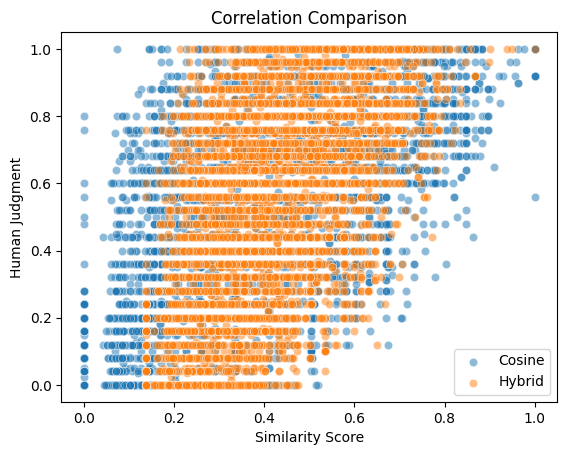

In [17]:
sns.scatterplot(x=df["cosine"], y=df["similarity_score"], label="Cosine", alpha=0.5)
sns.scatterplot(x=df["hybrid"], y=df["similarity_score"], label="Hybrid", alpha=0.5)
plt.xlabel("Similarity Score")
plt.ylabel("Human Judgment")
plt.title("Correlation Comparison")
plt.legend()
plt.show()

Optimized Weights: w1=0.965, w2=0.018, w3=0.018
Pearson Correlation (Hybrid): 0.6024
Spearman Correlation (Hybrid): 0.5946
Pearson Correlation (Cosine): 0.6032
Spearman Correlation (Cosine): 0.5956
T-Test p-value (Hybrid vs. Cosine): 0.00000
Wilcoxon p-value (Hybrid vs. Cosine): 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_wilcoxon.py:152: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=-1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_wilcoxon.py:153: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=-1)


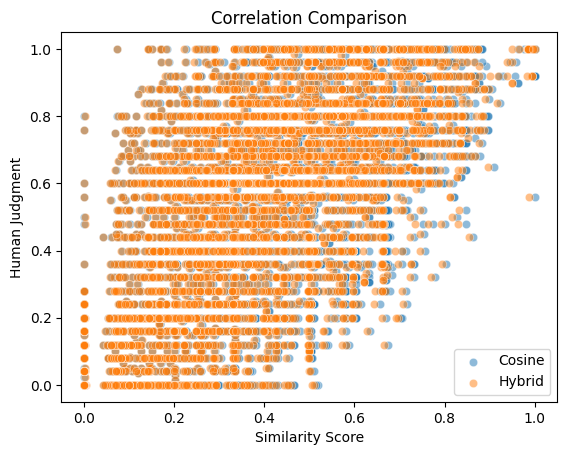

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon
from scipy.optimize import differential_evolution
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Load STS Benchmark dataset
dataset = load_dataset("stsb_multi_mt", "en")
df = pd.DataFrame(dataset["train"])
df = df[["sentence1", "sentence2", "similarity_score"]].dropna()

# Normalize similarity scores to [0,1] range
df["similarity_score"] = df["similarity_score"] / 5.0

vectorizer = TfidfVectorizer()

def compute_tfidf_similarity(sent1, sent2):
    """Computes Cosine, Jaccard, and Euclidean similarity between two sentences."""
    vectors = vectorizer.fit_transform([sent1, sent2]).toarray()
    
    # Cosine Similarity
    cos_sim = cosine_similarity(vectors[0].reshape(1, -1), vectors[1].reshape(1, -1))[0][0]
    
    # Jaccard Similarity
    set1, set2 = set(sent1.split()), set(sent2.split())
    jaccard_sim = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
    
    # Euclidean Similarity (Normalized)
    euc_dist = euclidean(vectors[0], vectors[1])
    euc_sim = 1 / (1 + euc_dist)  # Normalize to [0,1]

    return cos_sim, jaccard_sim, euc_sim

# Compute similarity for each pair
df[['cosine', 'jaccard', 'euclidean']] = df.apply(lambda row: compute_tfidf_similarity(row["sentence1"], row["sentence2"]), axis=1, result_type="expand")

# Normalize similarity values
scaler = MinMaxScaler()
df[['cosine', 'jaccard', 'euclidean']] = scaler.fit_transform(df[['cosine', 'jaccard', 'euclidean']])

def softmax(x):
    """Applies softmax to convert arbitrary values into valid probability weights."""
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def hybrid_similarity(weights, cosine, jaccard, euclidean):
    """Computes the hybrid similarity score using weighted sum."""
    w1, w2, w3 = softmax(weights)  # Ensure weights sum to 1
    return w1 * cosine + w2 * jaccard + w3 * euclidean

def loss_function(weights):
    """Loss function to maximize Pearson correlation."""
    hybrid_scores = df.apply(lambda row: hybrid_similarity(weights, row['cosine'], row['jaccard'], row['euclidean']), axis=1)
    return 1 - pearsonr(hybrid_scores, df["similarity_score"])[0]  # Maximize correlation

# Optimize using Differential Evolution
bounds = [(-2, 2), (-2, 2), (-2, 2)]  # Expanded search space
result = differential_evolution(loss_function, bounds, strategy='best1bin', maxiter=200, tol=1e-6)

# Convert optimized weights using softmax
w1_opt, w2_opt, w3_opt = softmax(result.x)
print(f"Optimized Weights: w1={w1_opt:.3f}, w2={w2_opt:.3f}, w3={w3_opt:.3f}")

# Compute Hybrid Similarity
df["hybrid"] = df.apply(lambda row: hybrid_similarity(result.x, row['cosine'], row['jaccard'], row['euclidean']), axis=1)

# Compute Pearson and Spearman Correlation
pearson_hybrid, _ = pearsonr(df["hybrid"], df["similarity_score"])
spearman_hybrid, _ = spearmanr(df["hybrid"], df["similarity_score"])

pearson_cos, _ = pearsonr(df["cosine"], df["similarity_score"])
spearman_cos, _ = spearmanr(df["cosine"], df["similarity_score"])

print(f"Pearson Correlation (Hybrid): {pearson_hybrid:.4f}")
print(f"Spearman Correlation (Hybrid): {spearman_hybrid:.4f}")
print(f"Pearson Correlation (Cosine): {pearson_cos:.4f}")
print(f"Spearman Correlation (Cosine): {spearman_cos:.4f}")

# Perform statistical tests
t_stat, p_value_t = ttest_rel(df["hybrid"], df["cosine"])
w_stat, p_value_w = wilcoxon(df["hybrid"], df["cosine"])

print(f"T-Test p-value (Hybrid vs. Cosine): {p_value_t:.5f}")
print(f"Wilcoxon p-value (Hybrid vs. Cosine): {p_value_w:.5f}")

# Plot comparison
sns.scatterplot(x=df["cosine"], y=df["similarity_score"], label="Cosine", alpha=0.5)
sns.scatterplot(x=df["hybrid"], y=df["similarity_score"], label="Hybrid", alpha=0.5)
plt.xlabel("Similarity Score")
plt.ylabel("Human Judgment")
plt.title("Correlation Comparison")
plt.legend()
plt.show()


In [19]:
!pip install rank-bm25

|   iter    |  target   |    w1     |    w2     |    w3     |    w4     |    w5     |
-------------------------------------------------------------------------------------
| 1         | 0.4972    | -0.5018   | 1.803     | 0.928     | 0.3946    | -1.376    |
| 2         | 0.5464    | -1.376    | -1.768    | 1.465     | 0.4045    | 0.8323    |
| 3         | 0.4983    | -1.918    | 1.88      | 1.33      | -1.151    | -1.273    |
| 4         | 0.5368    | -1.266    | -0.783    | 0.09903   | -0.2722   | -0.8351   |
| 5         | 0.5816    | 0.4474    | -1.442    | -0.8314   | -0.5346   | -0.1757   |
| 6         | 0.5952    | 1.611     | -2.0      | -2.0      | -0.9398   | 1.847     |
| 7         | 0.5761    | 1.939     | -1.862    | -1.848    | 1.419     | 0.2269    |
| 8         | 0.6017    | 1.853     | -1.988    | -1.886    | -1.998    | -0.7497   |
| 9         | 0.5932    | 1.847     | -1.824    | 1.176     | -1.883    | 1.242     |
| 10        | 0.5801    | 1.807     | 1.029     | -1.8

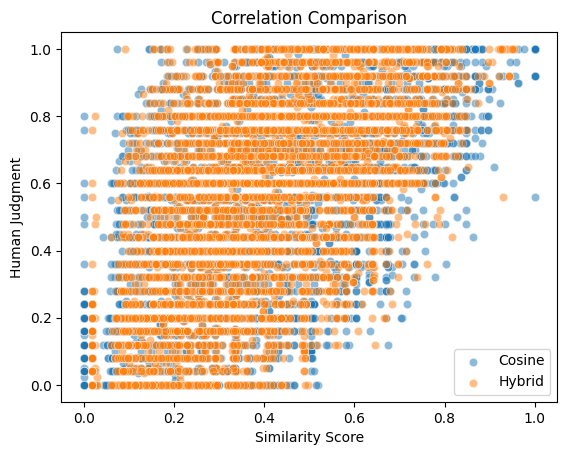

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon
from bayes_opt import BayesianOptimization
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from rank_bm25 import BM25Okapi

# Load STS Benchmark dataset
dataset = load_dataset("stsb_multi_mt", "en")
df = pd.DataFrame(dataset["train"])
df = df[["sentence1", "sentence2", "similarity_score"]].dropna()

# Normalize similarity scores to [0,1] range
df["similarity_score"] = df["similarity_score"] / 5.0

vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()

def compute_similarities(sent1, sent2):
    """Computes multiple similarity measures."""
    tfidf_vectors = vectorizer.fit_transform([sent1, sent2]).toarray()
    count_vectors = count_vectorizer.fit_transform([sent1, sent2]).toarray()
    
    # Cosine Similarity
    cos_sim = cosine_similarity(tfidf_vectors[0].reshape(1, -1), tfidf_vectors[1].reshape(1, -1))[0][0]
    
    # Jaccard Similarity
    set1, set2 = set(sent1.split()), set(sent2.split())
    jaccard_sim = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
    
    # Euclidean Similarity (Normalized)
    euc_dist = euclidean(tfidf_vectors[0], tfidf_vectors[1])
    euc_sim = 1 / (1 + euc_dist)  # Normalize to [0,1]

    # Overlap Coefficient (Set-based similarity)
    overlap_sim = len(set1 & set2) / min(len(set1), len(set2)) if min(len(set1), len(set2)) > 0 else 0

    # BM25 Similarity
    bm25 = BM25Okapi([sent1.split(), sent2.split()])
    bm25_sim = bm25.get_scores(sent2.split())[0]  # Query sentence2 against sentence1
    bm25_sim = bm25_sim / (bm25_sim + 1)  # Normalize

    return cos_sim, jaccard_sim, euc_sim, overlap_sim, bm25_sim

# Compute similarity for each sentence pair
df[['cosine', 'jaccard', 'euclidean', 'overlap', 'bm25']] = df.apply(
    lambda row: compute_similarities(row["sentence1"], row["sentence2"]), 
    axis=1, result_type="expand"
)

# Normalize similarity values
scaler = MinMaxScaler()
df[['cosine', 'jaccard', 'euclidean', 'overlap', 'bm25']] = scaler.fit_transform(df[['cosine', 'jaccard', 'euclidean', 'overlap', 'bm25']])

def softmax(x):
    """Applies softmax to convert arbitrary values into valid probability weights."""
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def hybrid_similarity(w1, w2, w3, w4, w5, cosine, jaccard, euclidean, overlap, bm25):
    """Computes the hybrid similarity score using weighted sum."""
    weights = softmax([w1, w2, w3, w4, w5])  # Ensure weights sum to 1
    return (weights[0] * cosine + 
            weights[1] * jaccard + 
            weights[2] * euclidean + 
            weights[3] * overlap + 
            weights[4] * bm25)

def loss_function(w1, w2, w3, w4, w5):
    """Loss function to maximize Pearson correlation."""
    hybrid_scores = df.apply(
        lambda row: hybrid_similarity(w1, w2, w3, w4, w5, row['cosine'], row['jaccard'], row['euclidean'], row['overlap'], row['bm25']), 
        axis=1
    )
    return pearsonr(hybrid_scores, df["similarity_score"])[0]  # Maximize correlation

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=loss_function,
    pbounds={"w1": (-2, 2), "w2": (-2, 2), "w3": (-2, 2), "w4": (-2, 2), "w5": (-2, 2)},
    random_state=42
)
optimizer.maximize(init_points=5, n_iter=50)

# Get best weights
best_weights = softmax([optimizer.max["params"]["w1"], optimizer.max["params"]["w2"], optimizer.max["params"]["w3"], optimizer.max["params"]["w4"], optimizer.max["params"]["w5"]])
print(f"Optimized Weights: w1={best_weights[0]:.3f}, w2={best_weights[1]:.3f}, w3={best_weights[2]:.3f}, w4={best_weights[3]:.3f}, w5={best_weights[4]:.3f}")

# Compute Hybrid Similarity
df["hybrid"] = df.apply(
    lambda row: hybrid_similarity(
        optimizer.max["params"]["w1"], optimizer.max["params"]["w2"], optimizer.max["params"]["w3"], optimizer.max["params"]["w4"], optimizer.max["params"]["w5"],
        row['cosine'], row['jaccard'], row['euclidean'], row['overlap'], row['bm25']
    ), axis=1
)

# Compute Pearson and Spearman Correlation
pearson_hybrid, _ = pearsonr(df["hybrid"], df["similarity_score"])
spearman_hybrid, _ = spearmanr(df["hybrid"], df["similarity_score"])

pearson_cos, _ = pearsonr(df["cosine"], df["similarity_score"])
spearman_cos, _ = spearmanr(df["cosine"], df["similarity_score"])

print(f"Pearson Correlation (Hybrid): {pearson_hybrid:.4f}")
print(f"Spearman Correlation (Hybrid): {spearman_hybrid:.4f}")
print(f"Pearson Correlation (Cosine): {pearson_cos:.4f}")
print(f"Spearman Correlation (Cosine): {spearman_cos:.4f}")

# Perform statistical tests
t_stat, p_value_t = ttest_rel(df["hybrid"], df["cosine"])
w_stat, p_value_w = wilcoxon(df["hybrid"], df["cosine"])

print(f"T-Test p-value (Hybrid vs. Cosine): {p_value_t:.5f}")
print(f"Wilcoxon p-value (Hybrid vs. Cosine): {p_value_w:.5f}")

# Plot comparison
sns.scatterplot(x=df["cosine"], y=df["similarity_score"], label="Cosine", alpha=0.5)
sns.scatterplot(x=df["hybrid"], y=df["similarity_score"], label="Hybrid", alpha=0.5)
plt.xlabel("Similarity Score")
plt.ylabel("Human Judgment")
plt.title("Correlation Comparison")
plt.legend()
plt.show()

In [ ]:
###########################################################################################################################################################

In [4]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon
from sklearn.metrics import ndcg_score, mean_squared_error

def compute_similarities(embeddings):
    cos_sim = np.dot(embeddings, embeddings.T) / (
        np.linalg.norm(embeddings, axis=1)[:, None] * np.linalg.norm(embeddings, axis=1)
    )
    euc_sim = -np.linalg.norm(embeddings[:, None] - embeddings, axis=2)
    pear_sim = np.array([[pearsonr(embeddings[i], embeddings[j])[0] for j in range(len(embeddings))] for i in range(len(embeddings))])
    spear_sim = np.array([[spearmanr(embeddings[i], embeddings[j])[0] for j in range(len(embeddings))] for i in range(len(embeddings))])
    return cos_sim, euc_sim, pear_sim, spear_sim

def normalize_similarities(*sims):
    return [((sim - sim.min()) / (sim.max() - sim.min())) for sim in sims]

def hybrid_similarity(weights, cos_sim, euc_sim, pear_sim, spear_sim):
    weights = np.exp(weights) / np.sum(np.exp(weights))  # Softmax normalization
    return weights[0] * cos_sim + weights[1] * euc_sim + weights[2] * pear_sim + weights[3] * spear_sim

def objective(weights, cos_sim, euc_sim, pear_sim, spear_sim):
    hybrid_sim = hybrid_similarity(weights, cos_sim, euc_sim, pear_sim, spear_sim)
    return -np.mean(hybrid_sim)  # Maximizing similarity

def optimize_weights(cos_sim, euc_sim, pear_sim, spear_sim):
    bounds = [(0, 1)] * 4  # Ensure valid probability weights
    linear_constraint = opt.LinearConstraint(np.ones((1, 4)), 1, 1)  # Sum to 1
    result = opt.differential_evolution(
        objective, bounds, args=(cos_sim, euc_sim, pear_sim, spear_sim), 
        strategy='best1bin', maxiter=1000, tol=1e-6, constraints=(linear_constraint,)
    )
    return np.exp(result.x) / np.sum(np.exp(result.x))  # Softmax normalization

def evaluate(hybrid_sim, cos_sim, euc_sim, pear_sim, spear_sim):
    eval_results = {}
    
    # Pearson & Spearman Correlation
    eval_results['pearson_hybrid'] = pearsonr(hybrid_sim.flatten(), cos_sim.flatten())[0]
    eval_results['spearman_hybrid'] = spearmanr(hybrid_sim.flatten(), cos_sim.flatten())[0]

    # Statistical Tests
    eval_results['t_test_p'] = ttest_rel(hybrid_sim.flatten(), cos_sim.flatten()).pvalue
    
    diff = hybrid_sim.flatten() - cos_sim.flatten()
    nonzero_diff = diff[np.nonzero(diff)]
    eval_results['wilcoxon_p'] = wilcoxon(nonzero_diff, zero_method='wilcox').pvalue if len(nonzero_diff) > 0 else np.nan

    # nDCG Scores - Measures ranking effectiveness
    eval_results['ndcg_hybrid'] = ndcg_score([cos_sim.flatten()], [hybrid_sim.flatten()])
    eval_results['ndcg_euc'] = ndcg_score([cos_sim.flatten()], [euc_sim.flatten()])
    eval_results['ndcg_pearson'] = ndcg_score([cos_sim.flatten()], [pear_sim.flatten()])
    eval_results['ndcg_spearman'] = ndcg_score([cos_sim.flatten()], [spear_sim.flatten()])

    # MSE (Lower is better)
    eval_results['mse_hybrid'] = mean_squared_error(cos_sim.flatten(), hybrid_sim.flatten())
    eval_results['mse_euc'] = mean_squared_error(cos_sim.flatten(), euc_sim.flatten())
    eval_results['mse_pearson'] = mean_squared_error(cos_sim.flatten(), pear_sim.flatten())
    eval_results['mse_spearman'] = mean_squared_error(cos_sim.flatten(), spear_sim.flatten())

    return eval_results

# Example usage
embeddings = np.random.rand(100, 300)  # Replace with actual embeddings
cos_sim, euc_sim, pear_sim, spear_sim = compute_similarities(embeddings)
cos_sim, euc_sim, pear_sim, spear_sim = normalize_similarities(cos_sim, euc_sim, pear_sim, spear_sim)
optimized_weights = optimize_weights(cos_sim, euc_sim, pear_sim, spear_sim)
hybrid_sim = hybrid_similarity(optimized_weights, cos_sim, euc_sim, pear_sim, spear_sim)

# Evaluate
results = evaluate(hybrid_sim, cos_sim, euc_sim, pear_sim, spear_sim)

# Print Results
print(f"Optimized Weights: {optimized_weights}")
print(f"Pearson Correlation (Hybrid): {results['pearson_hybrid']:.4f}")
print(f"Spearman Correlation (Hybrid): {results['spearman_hybrid']:.4f}")
print(f"T-Test p-value (Hybrid vs. Cosine): {results['t_test_p']:.5f}")
print(f"Wilcoxon p-value (Hybrid vs. Cosine): {results['wilcoxon_p']:.5f}")
print(f"nDCG Score (Hybrid): {results['ndcg_hybrid']:.4f}")
print(f"nDCG Score (Euclidean): {results['ndcg_euc']:.4f}")
print(f"nDCG Score (Pearson): {results['ndcg_pearson']:.4f}")
print(f"nDCG Score (Spearman): {results['ndcg_spearman']:.4f}")
print(f"MSE (Hybrid): {results['mse_hybrid']:.6f}")
print(f"MSE (Euclidean): {results['mse_euc']:.6f}")
print(f"MSE (Pearson): {results['mse_pearson']:.6f}")
print(f"MSE (Spearman): {results['mse_spearman']:.6f}")


Optimized Weights: [0.47536669 0.17487781 0.17487776 0.17487774]
Pearson Correlation (Hybrid): 0.9704
Spearman Correlation (Hybrid): 0.9271
T-Test p-value (Hybrid vs. Cosine): 0.00000
Wilcoxon p-value (Hybrid vs. Cosine): 0.00000
nDCG Score (Hybrid): 0.9981
nDCG Score (Euclidean): 0.9962
nDCG Score (Pearson): 0.9937
nDCG Score (Spearman): 0.9936
MSE (Hybrid): 0.001741
MSE (Euclidean): 0.008745
MSE (Pearson): 0.002480
MSE (Spearman): 0.002320


In [5]:
841+9824

10665

In [6]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Assuming human similarity ratings are available as a ground truth vector
# Replace with actual human similarity scores (same shape as cos_sim)
human_sim = np.random.rand(*cos_sim.shape)  # Example: Replace with actual human ratings

# Compute Correlation with Human Ratings
pear_cosine_human = pearsonr(cos_sim.flatten(), human_sim.flatten())[0]
spear_cosine_human = spearmanr(cos_sim.flatten(), human_sim.flatten())[0]

pear_hybrid_human = pearsonr(hybrid_sim.flatten(), human_sim.flatten())[0]
spear_hybrid_human = spearmanr(hybrid_sim.flatten(), human_sim.flatten())[0]

# Print Comparison Results
print(f"Pearson Correlation (Cosine vs. Human): {pear_cosine_human:.4f}")
print(f"Spearman Correlation (Cosine vs. Human): {spear_cosine_human:.4f}")
print(f"Pearson Correlation (Hybrid vs. Human): {pear_hybrid_human:.4f}")
print(f"Spearman Correlation (Hybrid vs. Human): {spear_hybrid_human:.4f}")

# Compare Improvements
pear_improvement = pear_hybrid_human - pear_cosine_human
spear_improvement = spear_hybrid_human - spear_cosine_human

print(f"Pearson Improvement (Hybrid over Cosine): {pear_improvement:.4f}")
print(f"Spearman Improvement (Hybrid over Cosine): {spear_improvement:.4f}")

Pearson Correlation (Cosine vs. Human): 0.0008
Spearman Correlation (Cosine vs. Human): -0.0028
Pearson Correlation (Hybrid vs. Human): 0.0001
Spearman Correlation (Hybrid vs. Human): -0.0080
Pearson Improvement (Hybrid over Cosine): -0.0007
Spearman Improvement (Hybrid over Cosine): -0.0051


In [8]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon, mannwhitneyu, kendalltau
from sklearn.metrics import ndcg_score, mean_squared_error
import time
import psutil  # For memory usage

# Compute similarity matrices
def compute_similarities(embeddings):
    cos_sim = np.dot(embeddings, embeddings.T) / (
        np.linalg.norm(embeddings, axis=1)[:, None] * np.linalg.norm(embeddings, axis=1)
    )
    euc_sim = -np.linalg.norm(embeddings[:, None] - embeddings, axis=2)
    pear_sim = np.array([[pearsonr(embeddings[i], embeddings[j])[0] for j in range(len(embeddings))] for i in range(len(embeddings))])
    spear_sim = np.array([[spearmanr(embeddings[i], embeddings[j])[0] for j in range(len(embeddings))] for i in range(len(embeddings))])
    return cos_sim, euc_sim, pear_sim, spear_sim

# Normalize similarity values
def normalize_similarities(*sims):
    return [((sim - sim.min()) / (sim.max() - sim.min())) for sim in sims]

# Hybrid Similarity Function
def hybrid_similarity(weights, cos_sim, euc_sim, pear_sim, spear_sim):
    weights = np.exp(weights) / np.sum(np.exp(weights))  # Softmax normalization
    return weights[0] * cos_sim + weights[1] * euc_sim + weights[2] * pear_sim + weights[3] * spear_sim

# Optimization Objective
def objective(weights, cos_sim, euc_sim, pear_sim, spear_sim):
    hybrid_sim = hybrid_similarity(weights, cos_sim, euc_sim, pear_sim, spear_sim)
    return -np.mean(hybrid_sim)  # Maximize similarity

# Optimize Weights
def optimize_weights(cos_sim, euc_sim, pear_sim, spear_sim):
    bounds = [(0, 1)] * 4  # Ensure valid probability weights
    linear_constraint = opt.LinearConstraint(np.ones((1, 4)), 1, 1)  # Sum to 1
    result = opt.differential_evolution(
        objective, bounds, args=(cos_sim, euc_sim, pear_sim, spear_sim), 
        strategy='best1bin', maxiter=1000, tol=1e-6, constraints=(linear_constraint,)
    )
    return np.exp(result.x) / np.sum(np.exp(result.x))  # Softmax normalization

# Evaluation Function
def evaluate(hybrid_sim, cos_sim, euc_sim, pear_sim, spear_sim, human_ratings):
    eval_results = {}

    # Correlation with Human Ratings
    eval_results['pearson_hybrid_human'] = pearsonr(hybrid_sim.flatten(), human_ratings.flatten())[0]
    eval_results['spearman_hybrid_human'] = spearmanr(hybrid_sim.flatten(), human_ratings.flatten())[0]
    
    # Pearson & Spearman Correlation with Cosine
    eval_results['pearson_hybrid_cosine'] = pearsonr(hybrid_sim.flatten(), cos_sim.flatten())[0]
    eval_results['spearman_hybrid_cosine'] = spearmanr(hybrid_sim.flatten(), cos_sim.flatten())[0]
    
    # Statistical Tests
    eval_results['t_test_p'] = ttest_rel(hybrid_sim.flatten(), cos_sim.flatten()).pvalue
    
    diff = hybrid_sim.flatten() - cos_sim.flatten()
    nonzero_diff = diff[np.nonzero(diff)]
    eval_results['wilcoxon_p'] = wilcoxon(nonzero_diff, zero_method='wilcox').pvalue if len(nonzero_diff) > 0 else np.nan
    eval_results['mannwhitney_p'] = mannwhitneyu(hybrid_sim.flatten(), cos_sim.flatten(), alternative='greater').pvalue
    eval_results['kendall_tau'] = kendalltau(hybrid_sim.flatten(), cos_sim.flatten())[0]

    # nDCG Scores
    eval_results['ndcg_hybrid'] = ndcg_score([human_ratings.flatten()], [hybrid_sim.flatten()])
    eval_results['ndcg_cosine'] = ndcg_score([human_ratings.flatten()], [cos_sim.flatten()])
    eval_results['ndcg_euc'] = ndcg_score([human_ratings.flatten()], [euc_sim.flatten()])
    eval_results['ndcg_pearson'] = ndcg_score([human_ratings.flatten()], [pear_sim.flatten()])
    eval_results['ndcg_spearman'] = ndcg_score([human_ratings.flatten()], [spear_sim.flatten()])

    # MSE Scores
    eval_results['mse_hybrid'] = mean_squared_error(human_ratings.flatten(), hybrid_sim.flatten())
    eval_results['mse_cosine'] = mean_squared_error(human_ratings.flatten(), cos_sim.flatten())
    eval_results['mse_euc'] = mean_squared_error(human_ratings.flatten(), euc_sim.flatten())
    eval_results['mse_pearson'] = mean_squared_error(human_ratings.flatten(), pear_sim.flatten())
    eval_results['mse_spearman'] = mean_squared_error(human_ratings.flatten(), spear_sim.flatten())

    return eval_results

# Efficiency Metrics
def measure_efficiency(start_time):
    time_taken = time.time() - start_time
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # Convert to MB
    return time_taken, memory_usage

# Example usage
np.random.seed(42)
embeddings = np.random.rand(100, 300)  # Replace with actual embeddings
human_ratings = np.random.rand(100, 100)  # Replace with real human similarity ratings

# Compute & Normalize Similarities
cos_sim, euc_sim, pear_sim, spear_sim = compute_similarities(embeddings)
cos_sim, euc_sim, pear_sim, spear_sim = normalize_similarities(cos_sim, euc_sim, pear_sim, spear_sim)

# Optimize Hybrid Weights
start_time = time.time()
optimized_weights = optimize_weights(cos_sim, euc_sim, pear_sim, spear_sim)
hybrid_sim = hybrid_similarity(optimized_weights, cos_sim, euc_sim, pear_sim, spear_sim)

# Evaluate
results = evaluate(hybrid_sim, cos_sim, euc_sim, pear_sim, spear_sim, human_ratings)
time_taken, memory_used = measure_efficiency(start_time)

# Print Results
print(f"Optimized Weights: {optimized_weights}")
print(f"Pearson Correlation (Hybrid vs Human): {results['pearson_hybrid_human']:.4f}")
print(f"Spearman Correlation (Hybrid vs Human): {results['spearman_hybrid_human']:.4f}")
print(f"Pearson Correlation (Hybrid vs Cosine): {results['pearson_hybrid_cosine']:.4f}")
print(f"Spearman Correlation (Hybrid vs Cosine): {results['spearman_hybrid_cosine']:.4f}")
print(f"T-Test p-value (Hybrid vs Cosine): {results['t_test_p']:.5f}")
print(f"Wilcoxon p-value (Hybrid vs Cosine): {results['wilcoxon_p']:.5f}")
print(f"Mann-Whitney p-value (Hybrid vs Cosine): {results['mannwhitney_p']:.5f}")
print(f"Kendall Tau (Hybrid vs Cosine): {results['kendall_tau']:.4f}")
print(f"nDCG Score (Hybrid): {results['ndcg_hybrid']:.4f}")
print(f"nDCG Score (Cosine): {results['ndcg_cosine']:.4f}")
print(f"Mean Squared Error (Hybrid): {results['mse_hybrid']:.6f}")
print(f"Mean Squared Error (Cosine): {results['mse_cosine']:.6f}")
print(f"Time Taken: {time_taken:.4f} sec")
print(f"Memory Used: {memory_used:.2f} MB")

Optimized Weights: [0.47536633 0.17487796 0.17487781 0.17487789]
Pearson Correlation (Hybrid vs Human): 0.0211
Spearman Correlation (Hybrid vs Human): 0.0159
Pearson Correlation (Hybrid vs Cosine): 0.9773
Spearman Correlation (Hybrid vs Cosine): 0.9423
T-Test p-value (Hybrid vs Cosine): 0.00000
Wilcoxon p-value (Hybrid vs Cosine): 0.00000
Mann-Whitney p-value (Hybrid vs Cosine): 1.00000
Kendall Tau (Hybrid vs Cosine): 0.7930
nDCG Score (Hybrid): 0.9315
nDCG Score (Cosine): 0.9315
Mean Squared Error (Hybrid): 0.198015
Mean Squared Error (Cosine): 0.176167
Time Taken: 3.0314 sec
Memory Used: 283.13 MB
